# <center> Noise

### Measurement configuration settings

<hr>
<div class="alert alert-block alert-success">
<b>Remark:</b> Please write the desired values below from the following possibilities: 
    <br> If the parameter is optional, you can write None and it will take a default value
</div>

| Parameter | <p style="text-align: left"> Possible values </p> | Datatype | Comments |
| --- | --- | --- | --- |
| sensor_name | <p style="text-align: left"> 'Mira030', 'Mira050', 'Mira130', 'Mira220' </p> | str | sensor product |
| port | <p style="text-align: left"> 0, 1 </p> | int | CSI port on nvidia 0 is closest to the power supply |
| bit_mode (optional) | <p style="text-align: left"> Mira030: 8bit, 10bit, 12bit <br> Mira050: 8bit, 10bit, 10bithighspeed, 12bit <br> Mira130: 8bit, 10bit <br> Mira220: 8bit, 10bit, 12bit </p> | str | bit depth for a pixel |
| fps (optional) | <p style="text-align: left"> Mira030: 1 - 180 <br> Mira050: 60 <br> Mira130: 30 <br> Mira220: 5 - 90 </p> | float | frame rate |
| w (optional) | <p style="text-align: left"> Mira030: 640 <br> Mira050: 600 <br> Mira130: 1080 <br> Mira220: 1600 </p> | int | width/amount of columns |
| h (optional) | <p style="text-align: left"> Mira030: 480 <br> Mira050: 800 <br> Mira130: 1280 <br> Mira220: 1400 </p> | int | height/amount of rows |
| analog_gain (optional) | <p style="text-align: left"> Mira030: 1- 15.5 <br> Mira050: 1, 2, 4 <br> Mira130: 1 - 28.547 <br> Mira220: 1</p> | int/float | analog gain |
| nb_imgs | <p style="text-align: left"> bigger than 0 </p> | int | number of image per exposure step |
| save_notebook_to_html | <p style="text-align: left"> True, False </p> | bool | save notebook outputs an html |
| notebook_name | <p style="text-align: left"> 'plotter_noise' </p> | str | this notebook name to save to an html |
| save_results_to_excel | <p style="text-align: left"> True, False </p> | bool | save tables to excel (data also present in html) |
| save_images | <p style="text-align: left"> True, False </p> | bool | save taken images to disk |
| grab_new_image_data | <p style="text-align: left"> True, False </p> | bool | perform ptc sweep or use stored dataset |

***

In [1]:
sensor_name = 'Mira050' #'Mira220'
port = 0
################################
bit_mode = None #'12bit'
fps = None #30
w = None #1600
h = None #1400
analog_gain = None #1
################################
nb_imgs = 50
################################
save_notebook_to_html = True
notebook_name = 'plotter_noise'
save_results_to_excel = True
save_images = True
grab_new_image_data = True

### Imports

In [2]:
import cv2
import numpy as np
import pandas as pd
import time
import os
import sys
import pickle
from datetime import datetime
import h5py
import characterization_ams.stats_engine.stats as stats
import characterization_ams.emva.emva as emva

sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
sys.path.append(os.path.dirname(os.getcwd()))
from ams_jetcis.scripts import sensor_script_example as scripts
import ams_jetcis.scripts.plotter as plotter

import plotly.io as pio
pio.renderers.default = 'jpg'

### Get image data

In [3]:
datestr = datetime.now().strftime('_%m-%d-%Y_%H%M%S')

In [4]:
if grab_new_image_data:
    # Parse input parameters
    select_sensor_params = {'sensor_name': sensor_name, 'port': port}
    init_sensor_params_temp = {'bit_mode' : bit_mode, 'fps' : fps, 'w' : w, 'h' : h, 'analog_gain' : analog_gain}
    init_sensor_params = {k: v for k, v in init_sensor_params_temp.items() if v is not None}
    
    # Initialise the sensor
    sensor = scripts.select_sensor(**select_sensor_params)
    sensor.cold_start()
    sensor.init_sensor(**init_sensor_params)
    sensor.exposure_us = sensor.get_exposure_limit()['min_exp_time']
    
    #Grab images 
    imgs = sensor.imager.grab_images(nb_imgs)
    
    # Create hdf5 file to store images
    results_path = f'{os.getcwd()}/results{datestr}/'
    if not os.path.exists(results_path):
        os.makedirs(results_path)
        
    with h5py.File(results_path + 'noise.hdf5','w') as h5py_file:
        h5py_file.attrs['Measurement'] = 'Noise'
        h5py_file.create_dataset('dark_imgs', data=imgs, compression='lzf')

else:
    # Load images from hdf5 file
    dir_name = input('Give the directory name. Press enter to continue...')
    with h5py.File(f'{os.getcwd()}/{dir_name}/noise.hdf5', 'r') as f:
        imgs = np.array(f['dark_imgs'])

Open card:
Current sensor loaded: mira050
Current jetpack loaded: 4.6
Current kernel loaded: Linux-4.9.253-tegra-aarch64-with-Ubuntu-18.04-bionic
Correct sensor driver loaded
Reset sensor low
Reset sensor high 
version is 33
mira050 detected
key unknown type 0
type is unknown
ina detected, sensor board mira050 is used
/home/jetcis/svn/software/trunk/sw/ams_jetcis/sensors/mira050/config_files/low_fpn/10-bit mode_anagain1_60fps_exp0.1ms_continuous_clk_datarate_1200_mclk_24.txt
property digital gain called
property exposure called
property analog gain called
property analog gain called
Offset clip is 408
Scale factor is 16.0
Temperature is None
50.6
setting exposure with setter


### Noise stats

In [5]:
noise_stats = stats.agg_results(imgs)
df = pd.DataFrame([emva.dsnu1288_stack(imgs)])
for cc in df.columns:
    col_name = cc + '_DN'
    df.rename(columns={cc: col_name}, inplace=True)
df.rename(columns=emva.ut.summ_col_rename(), inplace=True)
df = df[["Total DSNU [DN]", "Pix DSNU [DN]", "Col DSNU [DN]", "Row DSNU [DN]"]]
noise_stats = noise_stats.join(df)

In [6]:
noise_stats.T

,0
Mean [DN],37.789000
Total FPN [DN],0.333000
Pix FPN [DN],0.313000
Col FPN [DN],0.077000
Row FPN [DN],0.084000
Total Temp Noise [DN],0.840000
Pix Temp Noise [DN],0.722000
Col Temp Noise [DN],0.104000
Row Temp Noise [DN],0.418000
CFPN Ratio,10.892000


### Plot results

In [7]:
avg_im = stats.avg_img_stack(imgs)
std_im = np.sqrt(stats.tot_var_img_stack(imgs))

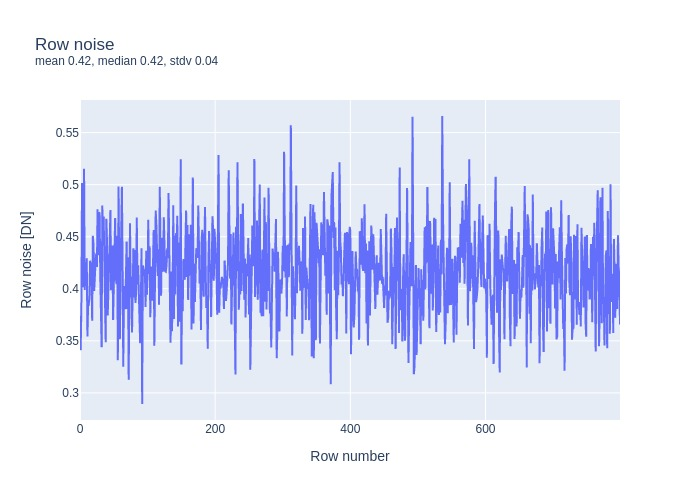

In [8]:
plotter.profile(stats.noise_profile(imgs, axis='row'),
                axis='Row', quantity='noise', unit='DN')

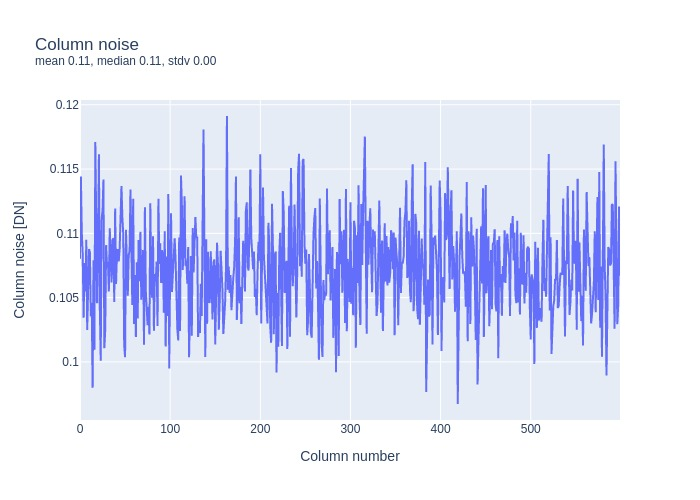

In [9]:
plotter.profile(stats.noise_profile(imgs, axis='column'),
                axis='Column', quantity='noise', unit='DN')

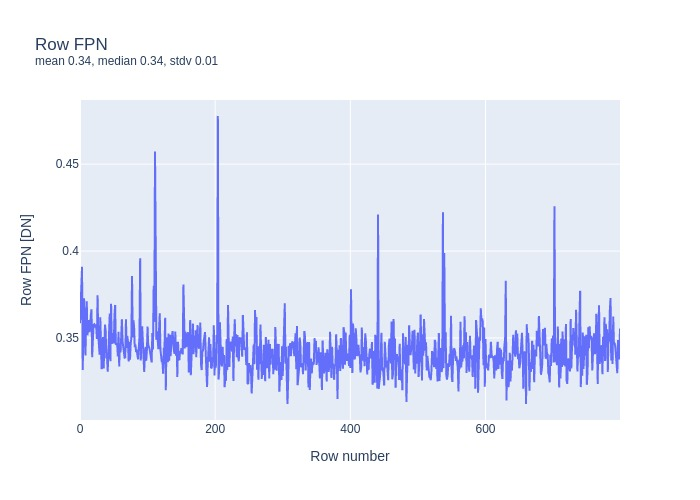

In [10]:
plotter.profile(stats.fpn_profile(imgs, axis='row'),
                axis='Row', quantity='FPN', unit='DN')

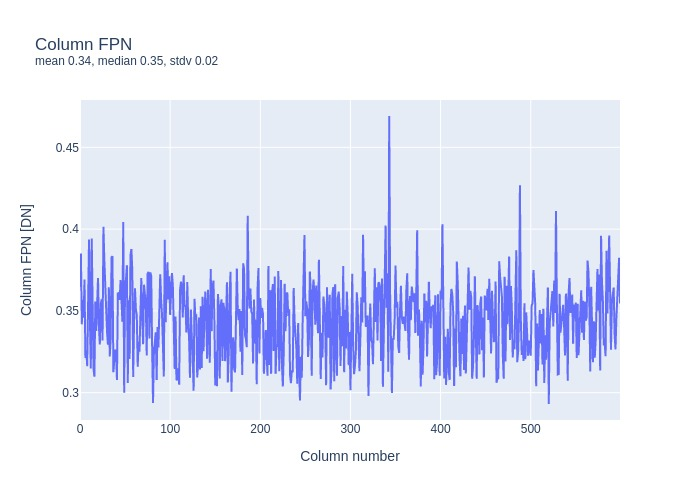

In [11]:
plotter.profile(stats.fpn_profile(imgs, axis='column'),
                axis='Column', quantity='FPN', unit='DN')

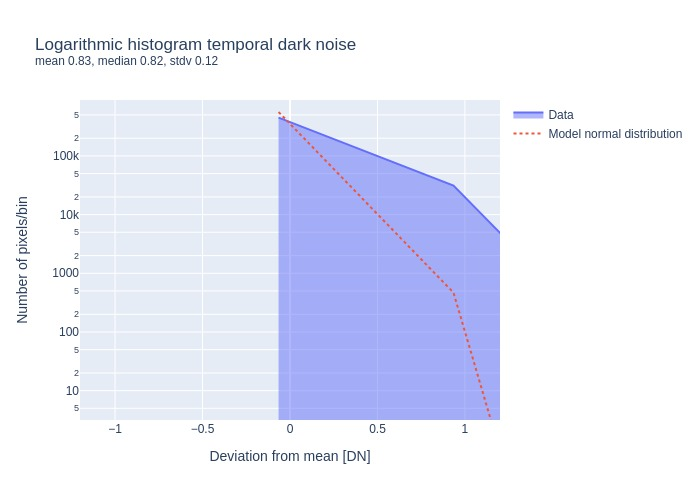

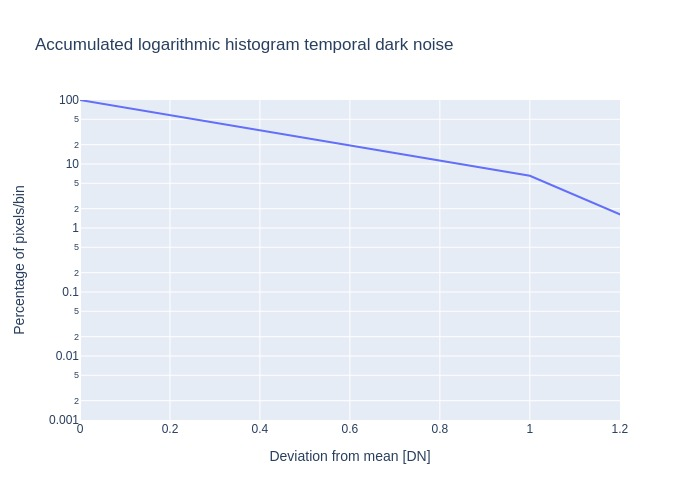

In [12]:
hist_tdn = emva.histogram1288(std_im, 256, imgs.shape[0], black_level=True)

plotter.histogram(std_im, hist_tdn, 
                  title='temporal dark noise', 
                  unit='DN', 
                  nb_limit_std=10)

plotter.accumulated_histogram(std_im, hist_tdn, 
                              title='temporal dark noise', 
                              unit='DN', 
                              nb_limit_std=10)

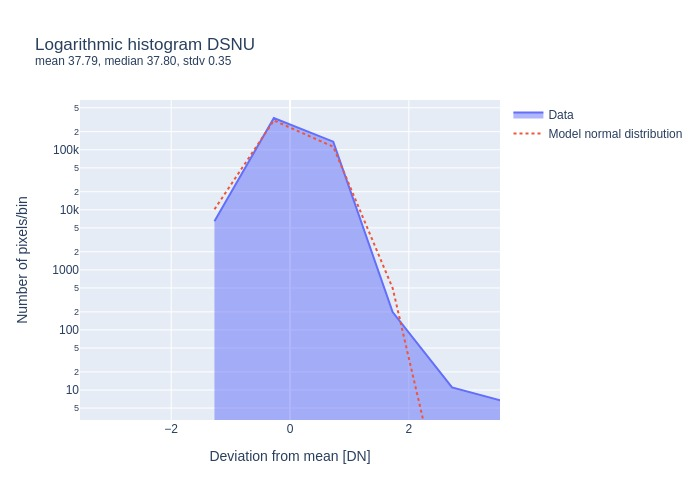

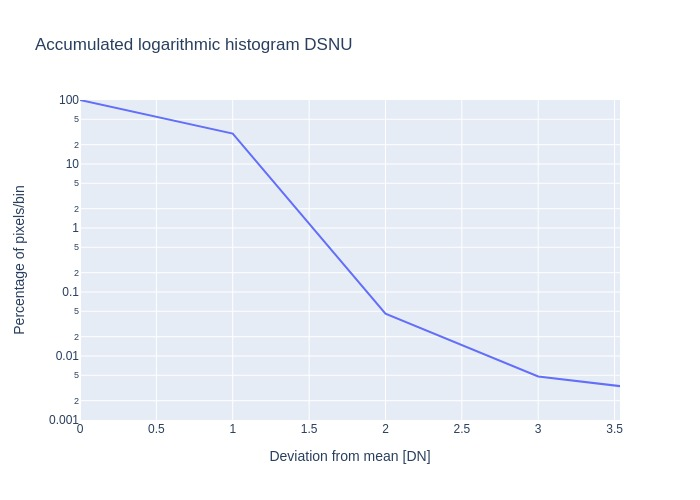

In [13]:
hist_dsnu = emva.histogram1288(avg_im, 256, imgs.shape[0], black_level=True)

plotter.histogram(avg_im, hist_dsnu, 
                  title='DSNU', 
                  unit='DN',  
                  nb_limit_std=10)

plotter.accumulated_histogram(avg_im, hist_dsnu, 
                              title='DSNU', 
                              unit='DN',  
                              nb_limit_std=10)

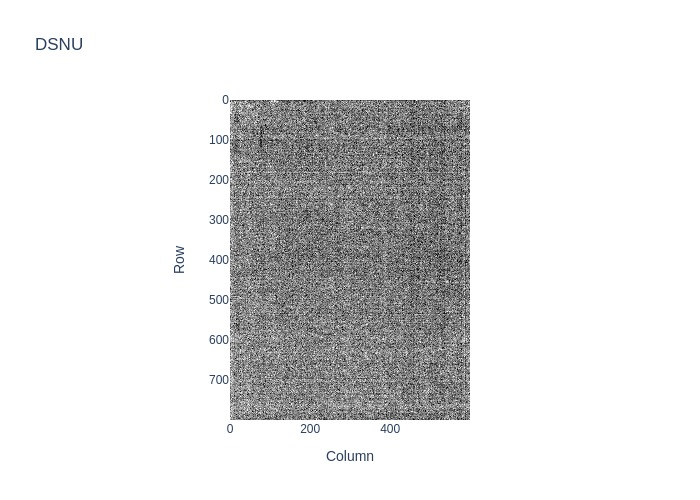

In [14]:
plotter.rowcolumn(avg_im,
                  np.max([0, (np.median(avg_im) - 3 * np.std(avg_im))]), 
                  np.median(avg_im) + 3 * np.std(avg_im),
                  title='DSNU')

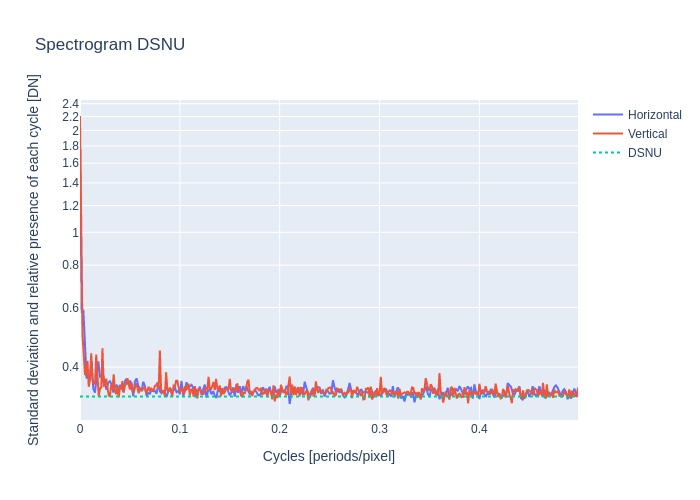

In [15]:
plotter.spectrogram(emva.spectrogram(avg_im), 
                    noise_stats['Total DSNU [DN]'][0], 
                    'DSNU')

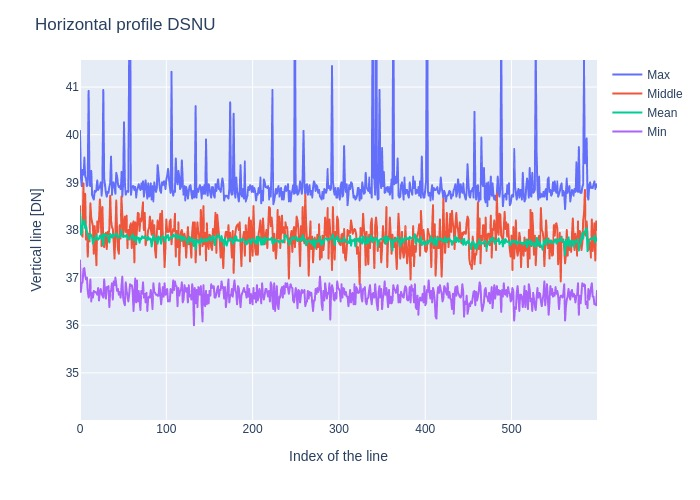

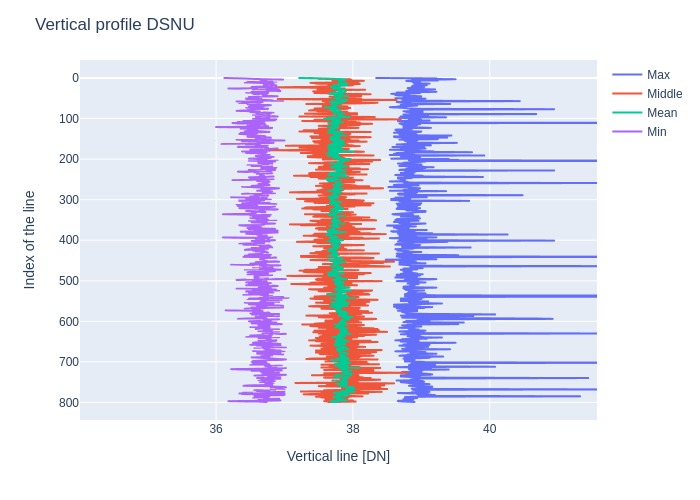

In [16]:
plotter.multi_profile(stats.profile(avg_im, horizontal=True),
                      param = 'DSNU',
                      orientation = 'Horizontal')
plotter.multi_profile(stats.profile(avg_im, horizontal=False),
                      param = 'DSNU',
                      orientation = 'Vertical')

### Save data

In [17]:
time.sleep(5)

In [18]:
%%javascript
IPython.notebook.save_checkpoint()
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

In [19]:
time.sleep(5)
# Save notebook to html
if save_notebook_to_html:
    path = os.getcwd() + '/'
    if os.path.exists(f'{path + notebook_name}.ipynb'):
        filename = notebook_name + '_notebook'
        
        results_path = path + f'results{datestr}/'
        if not os.path.exists(results_path):
            os.makedirs(results_path)
            
        !jupyter nbconvert --to html --template full {notebook_name}.ipynb --output {results_path + filename}.html
    else: 
        print('Please provide the correct notebook name!')

[NbConvertApp] Converting notebook plotter_noise.ipynb to html
[NbConvertApp] Writing 1059136 bytes to /home/jetcis/svn/software/trunk/sw/ams_jetcis/notebooks/results_01-25-2022_115842/plotter_noise_notebook.html


In [20]:
# save results to excel
if save_results_to_excel:
    filename = notebook_name + '_excel'
    
    path = os.getcwd() + '/'
    results_path = path + f'results{datestr}/'
    if not os.path.exists(results_path):
        os.makedirs(results_path)
    
    with pd.ExcelWriter(f'{results_path + filename}.xlsx') as writer:  
        noise_stats.to_excel(writer, sheet_name='noise_stats')